# architecture of VAE$_{clim \rightarrow clim + conv}$

In [1]:
from sklearn.decomposition import PCA

from tensorflow.keras.layers import Lambda, Input, Dense
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler,Callback


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


import tensorflow as tf
from cbrain.imports import *

from cbrain.utils import *
import pandas as ps

# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob

# kl annealing to improve reproduction skills of VAE 
klstart = 2
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 5

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(K.get_value(self.weight) + (1./kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))


# the starting value of weight is 0
# define it as a keras backend variable
weight = K.variable(0.)

    
original_dim_input=64  # input node size (CAM variables)

original_dim_output=int(65+64) # output node size (SP + CAM variables)


# network parameters
input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 463 # nodes in first hidden layers of encoder and last hidden layers of decoder 
batch_size = 714
latent_dim = 5 # latent space dimensions
epochs = 40    
    
## Encoder 
inputs =Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation='relu')(inputs)
x_1 =Dense(intermediate_dim, activation='relu')(x_0)
x_2 =Dense(int(np.round(intermediate_dim/2)), activation='relu')(x_1)
x_3 =Dense(int(np.round(intermediate_dim/4)), activation='relu')(x_2)
x_4 =Dense(int(np.round(intermediate_dim/8)), activation='relu')(x_3)
x_5 =Dense(int(np.round(intermediate_dim/16)), activation='relu')(x_4)



z_mean = Dense(latent_dim, name='z_mean')(x_5)
z_log_var = Dense(latent_dim, name='z_log_var')(x_5)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


## Decoder
decoder_inputs =Input(shape=(latent_dim,), name='decoder_input')
x_1 =Dense(int(np.round(intermediate_dim/16)), activation='relu')(decoder_inputs)
x_2 =Dense(int(np.round(intermediate_dim/8)), activation='relu')(x_1)
x_3 =Dense(int(np.round(intermediate_dim/4)), activation='relu')(x_2)
x_4 =Dense(int(np.round(intermediate_dim/2)), activation='relu')(x_3)
x_5 =Dense(intermediate_dim, activation='relu')(x_4)
x_6 =Dense(intermediate_dim, activation='relu')(x_5)

outputs = Dense(original_dim_output, activation='elu')(x_6)

decoder = Model(decoder_inputs, outputs, name='decoder')
decoder.summary()

emul_outputs=decoder(encoder(inputs)[2])

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
VAE_loss = K.mean(kl_loss*weight)


VAE_clim_clim_conv=Model(inputs,emul_outputs)
VAE_clim_clim_conv.add_loss(VAE_loss)
VAE_clim_clim_conv.add_metric(kl_loss, name='kl_loss', aggregation='mean')


#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/Scaling_cond_VAE.csv')


PHQ_std_surf=scale_array.PHQ_std.values[-1]

TPHYSTND_std_23=scale_array.TPHYSTND_std.values[-1]# for dT/dt we are using the std on level 23 ~ 845 hPa

PRECT_std=scale_array.PRECT_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values

# and the CAM variables 
scale_array_2D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range_profiles.csv')
scale_array_1D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range.csv')

TBP_std_surf=scale_array_2D.TBP_std.values[-1]

QBP_std_surf=scale_array_2D.QBP_std.values[-1]

Q_lat_std_surf=scale_array_1D.Q_lat_std.values

Q_sens_std_surf=scale_array_1D.Q_sens_std.values


Q_solar_std_surf=scale_array_1D.Q_sol_std.values

PS_std_surf=scale_array_1D.PS_std.values


# defining the scaling dict for the VAE training 

scale_dict_II = {
    'PHQ': 1/PHQ_std_surf, 
    'QBP':1/QBP_std_surf,
    'TPHYSTND': 1/TPHYSTND_std_23, 
    'TBP':1/TBP_std_surf,
    'FSNT': 1/FSNT_std, 
    'FSNS': 1/FSNS_std, 
    'FLNT': 1/FLNT_std, 
    'FLNS': 1/FLNS_std, 
    'PRECT': 1/PRECT_std, 
    'LHFLX': 1/Q_lat_std_surf, 
    'SHFLX': 1/Q_sens_std_surf, 
    'SOLIN': 1/Q_solar_std_surf,
    'PS':1/PS_std_surf
}

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT','QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']

## CAM variables
#QBP = specific humidity
#TBP = temperature 
#PS = surface pressure 
#SOLIN = solar insolation
#SHFLX = surface sensible heat flux 
#LHFLX = surface latent heat flux

##  SP variables=
#PHQ = specific humidity tendency 
#TPHYSTND = temperature tendency 
#FSNT = shortwave heat flux model top
#FSNS = shortwave heat flux model surface 
#FLNT = longwave heat flux model top (OLR)
#FLNS = longwave heat flux model surface 
#PRECT = precipitation rate 

# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


from cbrain.data_generator import DataGenerator

In /pf/b/b309162/work/miniconda3/envs/thunder_cpu_II_plot/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pf/b/b309162/work/miniconda3/envs/thunder_cpu_II_plot/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pf/b/b309162/work/miniconda3/envs/thunder_cpu_II_plot/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /pf/b/b309162/work/miniconda3/envs/thunder_cpu_II_plot/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was depreca

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 463)          30095       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 463)          214832      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 232)          107648      dense_1[0][0]                    
____________________________________________________________________________________________

In [2]:
#load the 3month SP test data set 
val_gen_II = DataGenerator(
    data_fn = '../preprocessed_data/1918_train_3_month_OND.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../preprocessed_data/000_norm_1_month.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=8192,
    shuffle=True
)


In [3]:
VAE_clim_clim_conv.load_weights('./saved_models/VAE_clim_clim_conv/VAE_clim_clim_conv_BN5_40_opt_anneal.h5')

In [4]:
# define latitude, longitude and time 
lat=np.arange(-90,90,180/64)
lon=np.arange(-180,180,360/128)
time=4415

In [5]:
#latitutde and longitude of each grid cell as function of time step  
latit_array=np.reshape((lat.T*np.ones((lat.size,lon.size)).T).T,int(lat.size*lon.size))
lonit_array=np.reshape(lon*np.ones((lat.size,lon.size)),int(lat.size*lon.size))

latit_timestep_array=np.reshape((latit_array.T*np.ones((latit_array.size,time)).T),int(latit_array.size*time))
lonit_timestep_array=np.reshape((lonit_array.T*np.ones((lonit_array.size,time)).T),int(lonit_array.size*time))


In [6]:
#load precomputed 5D latent space of VAE_clim_clim_conv

encoder_resp=np.load('VAE_clim_clim_conv_encoder_pred_3_month_global.npy')

In [7]:
#load saved predicted output data set for encoder_resp or predict output data using val_gen_II

VAE_resp=np.load('VAE_clim_clim_conv_pred_3_month_global.npy')#val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_resp))

swap nodes to seperate latent nodes which drive large-scale varaibility from convective regime latent nodes

original latent node 1 → Node 3

original latent node 2 → Node 2

original latent node 3 → Node 4

original latent node 4 → Node 5

original latent node 5 → Node 1

# Compute linear correlation R in space-time between latent nodes and output data set 

In [8]:
overall_corr_node_0=np.nan* np.zeros(VAE_resp[0].size)
overall_corr_node_1=np.nan* np.zeros(VAE_resp[0].size)
overall_corr_node_2=np.nan* np.zeros(VAE_resp[0].size)
overall_corr_node_3=np.nan* np.zeros(VAE_resp[0].size)
overall_corr_node_4=np.nan* np.zeros(VAE_resp[0].size)

## compute R for between respective latent nodes and output predictions
## order of latent nodes swapped 
for i in tqdm(np.arange(overall_corr_node_0.size)):
    
    overall_corr_node_0[i]=np.corrcoef(encoder_resp[:,4],VAE_resp[:,i])[0,1]
    overall_corr_node_1[i]=np.corrcoef(encoder_resp[:,1],VAE_resp[:,i])[0,1]
    overall_corr_node_2[i]=np.corrcoef(encoder_resp[:,0],VAE_resp[:,i])[0,1]
    overall_corr_node_3[i]=np.corrcoef(encoder_resp[:,2],VAE_resp[:,i])[0,1]
    overall_corr_node_4[i]=np.corrcoef(encoder_resp[:,3],VAE_resp[:,i])[0,1]


<ipython-input-8-540901828648>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(overall_corr_node_0.size)):


In [8]:
# generate variable list for sub-grid-scale SP varaibles
out_labels=['dq/dt '+str(np.round(P[0]/100)),
           'dq/dt '+str(np.round(P[1]/100)),
           'dq/dt '+str(np.round(P[2]/100)),
           'dq/dt '+str(np.round(P[3]/100)),
           'dq/dt '+str(np.round(P[4]/100)),
           'dq/dt '+str(np.round(P[5]/100)),
           'dq/dt '+str(np.round(P[6]/100)),
           'dq/dt '+str(np.round(P[7]/100)),
           'dq/dt '+str(np.round(P[8]/100)),
           'dq/dt '+str(np.round(P[9]/100)),
           'dq/dt '+str(np.round(P[10]/100)),
           'dq/dt '+str(np.round(P[11]/100)),
           'dq/dt '+str(np.round(P[12]/100)),
           'dq/dt '+str(np.round(P[13]/100)),
           'dq/dt '+str(np.round(P[14]/100)),
           'dq/dt '+str(np.round(P[15]/100)),
           'dq/dt '+str(np.round(P[16]/100)),
           'dq/dt '+str(np.round(P[17]/100)),
           'dq/dt '+str(np.round(P[18]/100)),
           'dq/dt '+str(np.round(P[19]/100)),
           'dq/dt '+str(np.round(P[20]/100)),
           'dq/dt '+str(np.round(P[21]/100)),
           'dq/dt '+str(np.round(P[22]/100)),
           'dq/dt '+str(np.round(P[23]/100)),
           'dq/dt '+str(np.round(P[24]/100)),
           'dq/dt '+str(np.round(P[25]/100)),
           'dq/dt '+str(np.round(P[26]/100)),
           'dq/dt '+str(np.round(P[27]/100)),
           'dq/dt '+str(np.round(P[28]/100)),
           'dq/dt '+str(np.round(P[29]/100)),
        'dT/dt '+str(np.round(P[0]/100)),'','','',        
        'dT/dt '+str(np.round(P[4]/100)),'','','','',
        'dT/dt '+str(np.round(P[9]/100)),'','','','',        
        'dT/dt '+str(np.round(P[14]/100)),'','','','',
        'dT/dt '+str(np.round(P[19]/100)),'','','','',
        'dT/dt '+str(np.round(P[24]/100)),'','','','',
        'dT/dt '+str(np.round(P[29]/100)),'Q_sw_top','Q_sw_surf','Q_lw_top','Q_lw_surf','precip']

## and large-scale climate variables of CAM 

in_labels=['Q '+str(np.round(P[0]/100)),
           'Q '+str(np.round(P[1]/100)),
           'Q '+str(np.round(P[2]/100)),
           'Q '+str(np.round(P[3]/100)),
           'Q '+str(np.round(P[4]/100)),
           'Q '+str(np.round(P[5]/100)),
           'Q '+str(np.round(P[6]/100)),
           'Q '+str(np.round(P[7]/100)),
           'Q '+str(np.round(P[8]/100)),
           'Q '+str(np.round(P[9]/100)),
           'Q '+str(np.round(P[10]/100)),
           'Q '+str(np.round(P[11]/100)),
           'Q '+str(np.round(P[12]/100)),
           'Q '+str(np.round(P[13]/100)),
           'Q '+str(np.round(P[14]/100)),
           'Q '+str(np.round(P[15]/100)),
           'Q '+str(np.round(P[16]/100)),
           'Q '+str(np.round(P[17]/100)),
           'Q '+str(np.round(P[18]/100)),
           'Q '+str(np.round(P[19]/100)),
           'Q '+str(np.round(P[20]/100)),
           'Q '+str(np.round(P[21]/100)),
           'Q '+str(np.round(P[22]/100)),
           'Q '+str(np.round(P[23]/100)),
           'Q '+str(np.round(P[24]/100)),
           'Q '+str(np.round(P[25]/100)),
           'Q '+str(np.round(P[26]/100)),
           'Q '+str(np.round(P[27]/100)),
           'Q '+str(np.round(P[28]/100)),
           'Q '+str(np.round(P[29]/100)),
        'T '+str(np.round(P[0]/100)),'','','',        
        'T '+str(np.round(P[4]/100)),'','','','',
        'T '+str(np.round(P[9]/100)),'','','','',        
        'T '+str(np.round(P[14]/100)),'','','','',
        'T '+str(np.round(P[19]/100)),'','','','',
        'T '+str(np.round(P[24]/100)),'','','','',
        'T '+str(np.round(P[29]/100)),'P_surf','Q_sol','Q_sens','Q_lat']



# add the two list, create one list over entire VAE predictions 
        
all_labels=out_labels+in_labels


In [10]:
def quad_plot_R2_updated(SP_output_corr_node_0_R_2,
                 SP_output_corr_node_1_R_2,
                 SP_output_corr_node_2_R_2,
                 SP_output_corr_node_3_R_2,
                 SP_output_corr_node_4_R_2,
                 press,labels):
    
    """
    author: Gunnar Behrens
    plot squared linear correlation in space-time between latent nodes and VAE_clim_clim_conv predictions
    as vertical profiles in pressure coordinates for 3D variables and retrieve R² space-time values for 2D
    variables
    
    SP_output_corr_node_*_R_2 -- squarred corr coefs of each latent node 
    press -- vertical axis in pressure coords
    labels -- predicted variable list
    
    """
                
    import pandas as pd 
    Press=press/100
    
    c_map=[[0,0,0,1],[1,0,1,1],[0,0,1,1],[0,0.4,0.5,1],[0.6,0.4,0,1]]
    plt.figure(1,(24,9))
    plt.subplot(1,4,1)
    plt.plot(SP_output_corr_node_0_R_2[0:30],Press[0:30],color=c_map[0],
             label='Node 1')
    plt.plot(SP_output_corr_node_1_R_2[0:30],Press[0:30],color=c_map[1],
             label='Node 2')
    plt.plot(SP_output_corr_node_2_R_2[0:30],Press[0:30],color=c_map[2],
             label='Node 3')
    plt.plot(SP_output_corr_node_3_R_2[0:30],Press[0:30],color=c_map[3],
             label='Node 4')
    plt.plot(SP_output_corr_node_4_R_2[0:30],Press[0:30],color=c_map[4],
             label='Node 5')
    plt.title('Specific Humidity Tend.', Fontsize=24)
    plt.legend(fontsize=17,loc=2)
    plt.ylabel('P [hPa]', Fontsize=24)
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.xlabel('R²', Fontsize=20)

    plt.xticks(Fontsize=16)
    plt.yticks(Fontsize=16)

    plt.grid(True)
    inv=plt.gca()
    inv.invert_yaxis()
    
    ax_2=plt.subplot(1,4,2)
    plt.plot(SP_output_corr_node_0_R_2[30:60],Press[0:30],color=c_map[0])
    plt.plot(SP_output_corr_node_1_R_2[30:60],Press[0:30],color=c_map[1])
    plt.plot(SP_output_corr_node_2_R_2[30:60],Press[0:30],color=c_map[2])
    plt.plot(SP_output_corr_node_3_R_2[30:60],Press[0:30],color=c_map[3])
    plt.plot(SP_output_corr_node_4_R_2[30:60],Press[0:30],color=c_map[4])
    plt.xticks(Fontsize=16)
    ax_2.set_yticklabels([])
    plt.xlabel('R²', Fontsize=20)

    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.grid(True)
    
    plt.title('Temperature Tend.', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()

    ax_3=plt.subplot(1,4,3)
    plt.plot(SP_output_corr_node_0_R_2[65:95],Press[0:30],color=c_map[0])
    plt.plot(SP_output_corr_node_1_R_2[65:95],Press[0:30],color=c_map[1])
    plt.plot(SP_output_corr_node_2_R_2[65:95],Press[0:30],color=c_map[2])
    plt.plot(SP_output_corr_node_3_R_2[65:95],Press[0:30],color=c_map[3])
    plt.plot(SP_output_corr_node_4_R_2[65:95],Press[0:30],color=c_map[4])
    plt.xticks(Fontsize=16)
    ax_3.set_yticklabels([])
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.xlabel('R²', Fontsize=20)
    plt.grid(True)
    plt.title('Specific Humidity', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()
    
    ax_4=plt.subplot(1,4,4)
    plt.plot(SP_output_corr_node_0_R_2[95:125],Press[0:30],color=c_map[0])
    plt.plot(SP_output_corr_node_1_R_2[95:125],Press[0:30],color=c_map[1])
    plt.plot(SP_output_corr_node_2_R_2[95:125],Press[0:30],color=c_map[2])
    plt.plot(SP_output_corr_node_3_R_2[95:125],Press[0:30],color=c_map[3])
    plt.plot(SP_output_corr_node_4_R_2[95:125],Press[0:30],color=c_map[4])
    plt.xticks(Fontsize=16)
    ax_4.set_yticklabels([])
    plt.legend(fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.xlabel('R²', Fontsize=20)

    plt.grid(True)
    plt.title('Temperature', Fontsize=24 )
    inv=plt.gca()
    inv.invert_yaxis()

    
    
    scalar=[60,61,62,63,64,125,126,127,128]
    
    dg=pd.DataFrame([[labels[k],SP_output_corr_node_0_R_2[k],
                     SP_output_corr_node_1_R_2[k],
                     SP_output_corr_node_2_R_2[k],
                     SP_output_corr_node_3_R_2[k],
                     SP_output_corr_node_4_R_2[k]] for k in scalar],
                    columns=['Variable','Node 0', 'Node 1','Node 2', 'Node 3','Node 4'])
    
    
    
    
    
    return dg

<ipython-input-10-dd10d52bdd82>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Specific Humidity Tend.', Fontsize=24)
<ipython-input-10-dd10d52bdd82>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('P [hPa]', Fontsize=24)
<ipython-input-10-dd10d52bdd82>:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('R²', Fontsize=20)
<ipython-input-10-dd10d52bdd82>:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-10-dd10d52bdd82>:44: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  p

,Variable,Node 0,Node 1,Node 2,Node 3,Node 4
0,Q_sw_top,0.022536,0.000226,0.007286,0.002935,0.010922
1,Q_sw_surf,0.019803,0.000021,0.012929,0.001227,0.014973
2,Q_lw_top,0.380701,0.004512,0.004880,0.026072,0.138228
3,Q_lw_surf,0.024164,0.003606,0.102426,0.044361,0.110152
4,precip,0.000304,0.025659,0.094594,0.050430,0.114917
5,P_surf,0.249115,0.064701,0.164113,0.001247,0.056124
6,Q_sol,0.021120,0.000337,0.003817,0.011152,0.001386
7,Q_sens,0.029323,0.054308,0.053141,0.001323,0.047997
8,Q_lat,0.185645,0.255081,0.004882,0.139063,0.180241


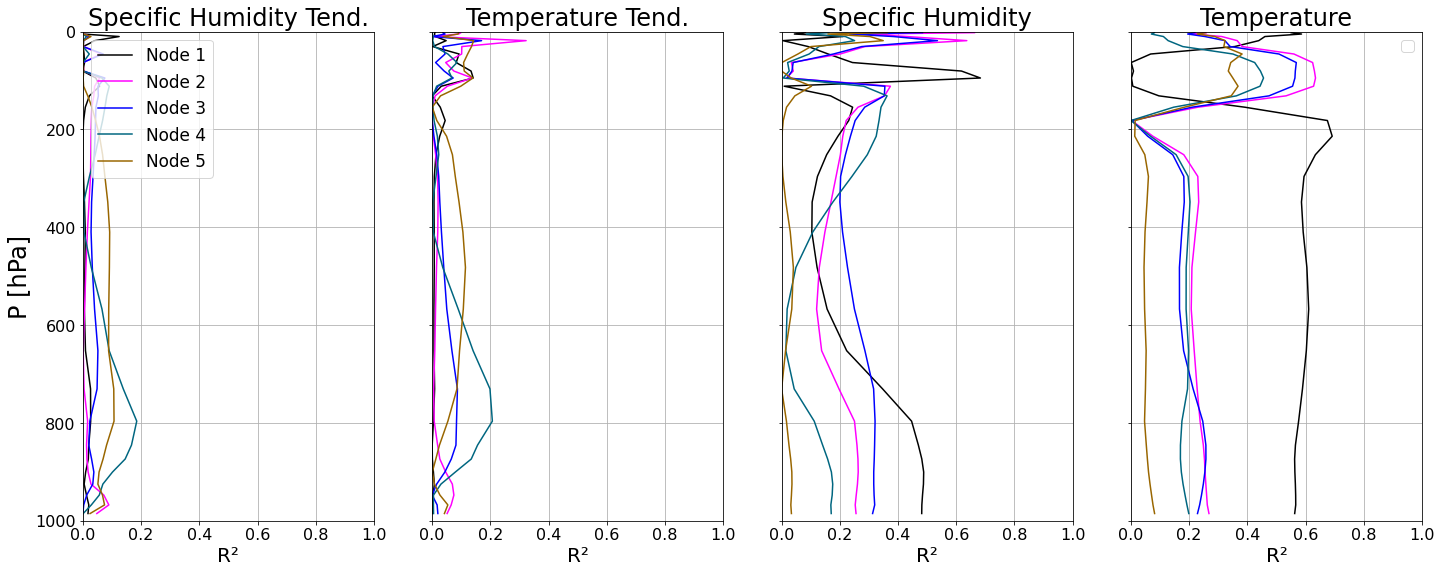

In [11]:
# plot vertical linear R² profiles in space-time 
quad_plot_R2_updated(overall_corr_node_0**2,
             overall_corr_node_1**2,
             overall_corr_node_2**2,
             overall_corr_node_3**2,
             overall_corr_node_4**2,
             P,all_labels)

In [9]:
## transform encoder_resp and VAE_resp from space-time data sets into 3D arrays with (time, latitude*longitude, dim_3.size)

encoder_resp_matr=np.reshape(encoder_resp,(time,lat.size*lon.size,encoder_resp[0,:].size))
output_resp_matr=np.reshape(VAE_resp,(time,lat.size*lon.size,VAE_resp[0,:].size))


# compute median squared linear correlation along time axis of 3D data arrays 

compute the linear correlation between latent nodes and the output data array in each horizontal grid cell 

In [10]:
overall_corr_node_0_lat_lon=np.nan* np.zeros((output_resp_matr[0,:,0].size,output_resp_matr[0,0,:].size))
overall_corr_node_1_lat_lon=np.nan* np.zeros((output_resp_matr[0,:,0].size,output_resp_matr[0,0,:].size))
overall_corr_node_2_lat_lon=np.nan* np.zeros((output_resp_matr[0,:,0].size,output_resp_matr[0,0,:].size))
overall_corr_node_3_lat_lon=np.nan* np.zeros((output_resp_matr[0,:,0].size,output_resp_matr[0,0,:].size))
overall_corr_node_4_lat_lon=np.nan* np.zeros((output_resp_matr[0,:,0].size,output_resp_matr[0,0,:].size))


for i in tqdm(np.arange(overall_corr_node_0_lat_lon[:,1].size)):
    
    for j in np.arange(overall_corr_node_0_lat_lon[1,:].size):

        overall_corr_node_0_lat_lon[i,j]=np.corrcoef(encoder_resp_matr[:,i,4],output_resp_matr[:,i,j])[0,1]
        overall_corr_node_1_lat_lon[i,j]=np.corrcoef(encoder_resp_matr[:,i,1],output_resp_matr[:,i,j])[0,1]
        overall_corr_node_2_lat_lon[i,j]=np.corrcoef(encoder_resp_matr[:,i,0],output_resp_matr[:,i,j])[0,1]
        overall_corr_node_3_lat_lon[i,j]=np.corrcoef(encoder_resp_matr[:,i,2],output_resp_matr[:,i,j])[0,1]
        overall_corr_node_4_lat_lon[i,j]=np.corrcoef(encoder_resp_matr[:,i,3],output_resp_matr[:,i,j])[0,1]


<ipython-input-10-387862e6db26>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(overall_corr_node_0_lat_lon[:,1].size)):


plot the median of R² values as a function of pressure for 3D variables and construct table for 2D variables 

In [11]:
def quad_plot_PC_R_2_updated(SP_output_corr_node_0_R_2,
                 SP_output_corr_node_1_R_2,
                 SP_output_corr_node_2_R_2,
                 SP_output_corr_node_3_R_2,
                 SP_output_corr_node_4_R_2,
                 press,labels):
    
    """
    author: Gunnar Behrens
    
    plot squared linear correlation in time between latent nodes and VAE_clim_clim_conv predictions
    as vertical profiles in pressure coordinates for 3D variables and retrieve R² space-time values for 2D
    variables
    
    SP_output_corr_node_*_R_2 -- squarred corr coefs of each latent node 
    press -- vertical axis in pressure coords
    labels -- predicted variable list
    
    """
    
                
    import pandas as pd 
    Press=press/100
    
    c_map=[[0,0,0,1],[1,0,1,1],[0,0,1,1],[0,0.4,0.5,1],[0.6,0.4,0,1]]
    plt.figure(1,(24,9))
    plt.subplot(1,4,1)
    plt.plot(SP_output_corr_node_0_R_2[0:30],Press[0:30],color=c_map[0],
             label='Node 1')
    plt.plot(SP_output_corr_node_1_R_2[0:30],Press[0:30],color=c_map[1],
             label='Node 2')
    plt.plot(SP_output_corr_node_2_R_2[0:30],Press[0:30],color=c_map[2],
             label='Node 3')
    plt.plot(SP_output_corr_node_3_R_2[0:30],Press[0:30],color=c_map[3],
             label='Node 4')
    plt.plot(SP_output_corr_node_4_R_2[0:30],Press[0:30],color=c_map[4],
             label='Node 5')
    plt.title('Specific Humidity Tend.', Fontsize=24)
    plt.legend(fontsize=17,loc=2)
    plt.ylabel('Pressure [hPa]', Fontsize=24)
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.xlabel('Median R²', Fontsize=20)

    plt.xticks(Fontsize=16)
    plt.yticks(Fontsize=16)

    plt.grid(True)
    inv=plt.gca()
    inv.invert_yaxis()
    
    ax_2=plt.subplot(1,4,2)
    plt.plot(SP_output_corr_node_0_R_2[30:60],Press[0:30],color=c_map[0])
    plt.plot(SP_output_corr_node_1_R_2[30:60],Press[0:30],color=c_map[1])
    plt.plot(SP_output_corr_node_2_R_2[30:60],Press[0:30],color=c_map[2])
    plt.plot(SP_output_corr_node_3_R_2[30:60],Press[0:30],color=c_map[3])
    plt.plot(SP_output_corr_node_4_R_2[30:60],Press[0:30],color=c_map[4])
    plt.xticks(Fontsize=16)
    ax_2.set_yticklabels([])
    plt.xlabel('Median R²', Fontsize=20)

    #plt.legend(fontsize=12)
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.grid(True)
    
    plt.title('Temperature Tend.', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()

    ax_3=plt.subplot(1,4,3)
    plt.plot(SP_output_corr_node_0_R_2[65:95],Press[0:30],color=c_map[0])
    plt.plot(SP_output_corr_node_1_R_2[65:95],Press[0:30],color=c_map[1])
    plt.plot(SP_output_corr_node_2_R_2[65:95],Press[0:30],color=c_map[2])
    plt.plot(SP_output_corr_node_3_R_2[65:95],Press[0:30],color=c_map[3])
    plt.plot(SP_output_corr_node_4_R_2[65:95],Press[0:30],color=c_map[4])
    plt.xticks(Fontsize=16)
    ax_3.set_yticklabels([])
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.xlabel('Median R²', Fontsize=20)
    plt.grid(True)
    plt.title('Specific Humidity', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()
    
    ax_4=plt.subplot(1,4,4)
    plt.plot(SP_output_corr_node_0_R_2[95:125],Press[0:30],color=c_map[0])
    plt.plot(SP_output_corr_node_1_R_2[95:125],Press[0:30],color=c_map[1])
    plt.plot(SP_output_corr_node_2_R_2[95:125],Press[0:30],color=c_map[2])
    plt.plot(SP_output_corr_node_3_R_2[95:125],Press[0:30],color=c_map[3])
    plt.plot(SP_output_corr_node_4_R_2[95:125],Press[0:30],color=c_map[4])
    plt.xticks(Fontsize=16)
    ax_4.set_yticklabels([])
    plt.legend(fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1000])
    plt.xlabel('Median R²', Fontsize=20)

    plt.grid(True)
    plt.title('Temperature', Fontsize=24 )
    inv=plt.gca()
    inv.invert_yaxis()

    
    
    scalar=[60,61,62,63,64,125,126,127,128]
    
    dg=pd.DataFrame([[labels[k],SP_output_corr_node_0_R_2[k],
                     SP_output_corr_node_1_R_2[k],
                     SP_output_corr_node_2_R_2[k],
                     SP_output_corr_node_3_R_2[k],
                     SP_output_corr_node_4_R_2[k]] for k in scalar],
                    columns=['Variable','Node 0', 'Node 1','Node 2', 'Node 3','Node 4'])
    
    
    
    
    
    return dg

<ipython-input-11-fc037c58d525>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Specific Humidity Tend.', Fontsize=24)
<ipython-input-11-fc037c58d525>:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Pressure [hPa]', Fontsize=24)
<ipython-input-11-fc037c58d525>:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Median R²', Fontsize=20)
<ipython-input-11-fc037c58d525>:45: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-11-fc037c58d525>:46: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor rele

,Variable,Node 0,Node 1,Node 2,Node 3,Node 4
0,Q_sw_top,0.282446,0.493557,0.039051,0.002188,0.406525
1,Q_sw_surf,0.243899,0.404486,0.022893,0.004742,0.437614
2,Q_lw_top,0.077431,0.025012,0.124987,0.093804,0.430694
3,Q_lw_surf,0.018310,0.011081,0.364192,0.100969,0.377696
4,precip,0.026463,0.007691,0.165979,0.289373,0.362049
5,P_surf,0.024961,0.015552,0.119257,0.330712,0.031710
6,Q_sol,0.338559,0.589743,0.075247,0.002793,0.279844
7,Q_sens,0.046937,0.050672,0.465673,0.032643,0.031779
8,Q_lat,0.042860,0.028747,0.537886,0.031483,0.036776


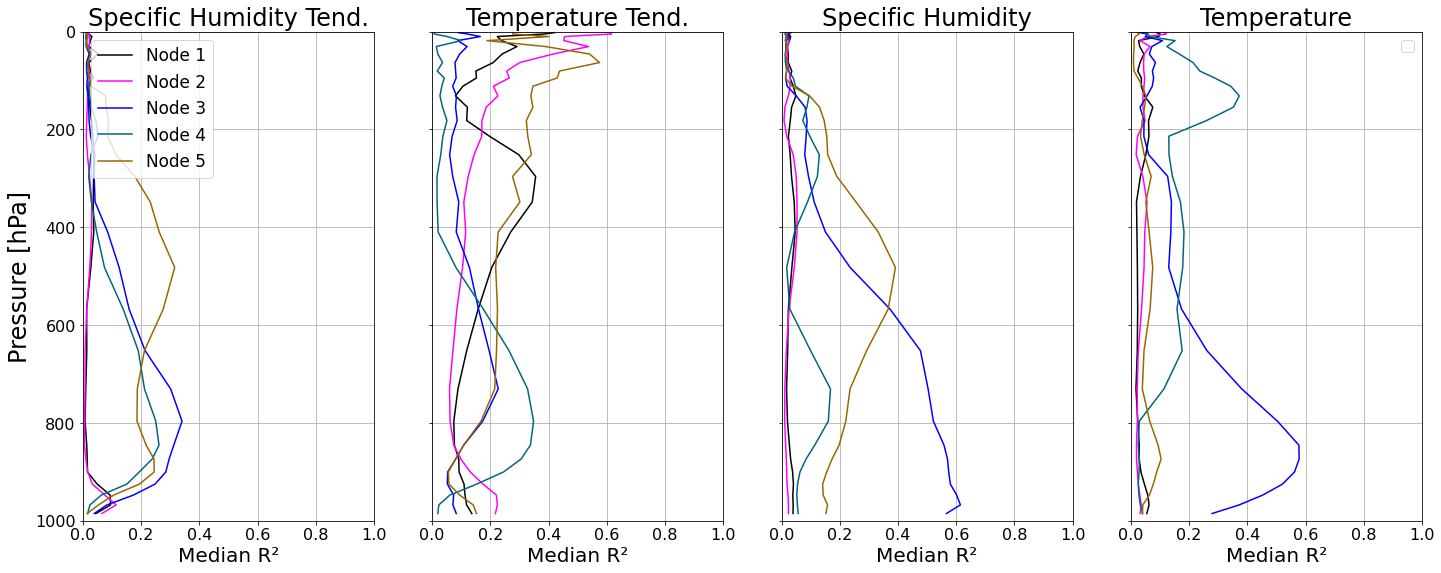

In [12]:
# compute median squared linear correlation coefficients along time axis, plot results 
quad_plot_PC_R_2_updated(np.median(overall_corr_node_0_lat_lon**2,0),
             np.median(overall_corr_node_1_lat_lon**2,0),
             np.median(overall_corr_node_2_lat_lon**2,0),
             np.median(overall_corr_node_3_lat_lon**2,0),
             np.median(overall_corr_node_4_lat_lon**2,0),
             P,all_labels)